##**installing pytorch and detectron2** 

In [ ]:
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install detectron2==0.6 -f \
https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [ ]:
!pip install rembg[gpu]

In [ ]:
#!pip install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#!pip install detectron2==0.6 -f \
#https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html

In [ ]:
!nvidia-smi

Mon Oct 17 11:50:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
print(torch.__version__, torch.cuda.is_available())

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer , ColorMode, _create_text_labels
from detectron2.utils.colormap import random_color

from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.10 ; cuda:  cu111
detectron2: 0.6
1.10.1+cu111 True


In [ ]:
import cv2 as cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import PIL 
import numpy as np
import json
import random
import shutil
import glob
#import rembg
import pandas as pd
import copy
#import albumentations as A

In [ ]:
os.chdir("/content/drive/MyDrive/pharmacy/")

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1of130zC4WOxL1MV2r7snVPEROqNr9fgT/pharmacy'

In [ ]:
#!zip "/content/drive/MyDrive/pharmacy.zip" "/content/drive/MyDrive/pharmacy"

In [ ]:
'''
from zipfile import ZipFile
zf = ZipFile('./test_blended_img.zip', 'r')
zf.extractall('./data/')
zf.close()
'''

## register dataset

In [ ]:
def get_dataset_dicts(p):
  with open(p+".json","r") as f:
    data_dict = json.load(f)
  return data_dict

In [ ]:
for d in ["train", "test"]:
    DatasetCatalog.register("data_" + d, lambda d=d: get_dataset_dicts("./data/" + d))
    MetadataCatalog.get("data_" + d).set(thing_classes=['cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette'])
train_metadata = MetadataCatalog.get("data_train")

In [ ]:
train_metadata

Metadata(name='data_train', thing_classes=['cycloff', 'bibron', 'cortéma', 'laroche_posay', 'soulagel', 'sucette'])

In [ ]:
data_train_name = "data_train"
data_test_name = "data_test"

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "./"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster (default: 512)
cfg.DATASETS.TRAIN = (data_train_name,)
cfg.DATASETS.TEST = (data_test_name,)
# ("fashion_train",)

cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.BASE_LR = 0.001  
# pick a good LR

cfg.SOLVER.MAX_ITER = 8200 #2160
# The iteration number to decrease learning rate by GAMMA. to decay lr (12,17)
cfg.SOLVER.STEPS = (5740,)
cfg.SOLVER.gamma = 0.5
cfg.SOLVER.IMS_PER_BATCH = 4
# after each epc        # do not decay learning rate
cfg.SOLVER.CHECKPOINT_PERIOD = 82 #  36*2

#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.DEVICE = "cuda"

In [ ]:
len(DatasetCatalog.get(data_train_name))

6788

In [ ]:
#dataset_test_dicts = DatasetCatalog.get(data_test_name)
train_dict = DatasetCatalog.get(data_train_name)

In [ ]:
len(dataset_test_dicts)

464

In [ ]:
dataset_test_dicts[-1]

{'file_name': './data/test/1004.jpg',
 'height': 2400,
 'width': 2100,
 'image_id': 1004,
 'annotations': [{'iscrowd': 0,
   'bbox': [994, 1284, 1555, 1976],
   'category_id': 5,
   'bbox_mode': 1}]}

In [ ]:
train_metadata = MetadataCatalog.get(data_train_name)

In [ ]:
test_metadata.thing_classes

['cycloff', 'bibron', 'cortéma', 'laroche_posay', 'soulagel', 'sucette']

In [ ]:
with open("./data/test_long4.json","r") as dp:
  dict_test2 = json.load(dp)

In [ ]:
detectron2.data.print_instances_class_histogram(train_dict, train_metadata.thing_classes)

[10/21 06:25:04 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cycloff    | 556          |   bibron   | 1383         |  cortéma   | 1108         |
| laroche_posay | 1813         |  soulagel  | 1387         |  sucette   | 560          |
|               |              |            |              |            |              |
|     total     | 6807         |            |              |            |              |


In [ ]:
len(dict_test2)

512

In [ ]:
detectron2.data.print_instances_class_histogram(dataset_test_dicts, train_metadata.thing_classes)

[10/12 21:56:57 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cycloff    | 74           |   bibron   | 85           |  cortéma   | 68           |
| laroche_posay | 78           |  soulagel  | 85           |  sucette   | 74           |
|               |              |            |              |            |              |
|     total     | 464          |            |              |            |              |


In [ ]:
len(dataset_train_dicts)

5679

In [ ]:
len(dataset_test_dicts)

54

In [ ]:
with open("./data/test.json",'w') as gp:
  json.dump(dataset_test_dicts,gp)

In [ ]:
with open("./data/train.json","r") as np:
  train_dict = json.load(np)

**Simple Training**

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Test

In [ ]:
register_coco_instances("data_test", {}, "/home/iovision/Documents/dataset/PH_train2/coco_test2_2.json", "/home/iovision/Documents/dataset/PH_test2/image/")

#%%
cfg = get_cfg()
cfg.OUTPUT_DIR = "./Pharmacie/logs_data_aug"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0001059.pth")  # path to the model we just trained


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster (default: 512)
cfg.DATASETS.TEST = (data_test_name)
# ("fashion_train",)

cfg.DATALOADER.NUM_WORKERS = 4


cfg.SOLVER.IMS_PER_BATCH = 16


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.DEVICE = "cuda"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("data_test",tasks=("bbox",),output_dir="./Pharmacie")

val_loader = build_detection_test_loader(cfg, "data_test")

data = inference_on_dataset(predictor.model, val_loader, evaluator)

print(data)
with open('/home/iovision/Documents/Detectron2/Pharmacie/fisrst_training_result5.json', 'w') as fp:
        json.dump(data, fp)

In [ ]:
#%%
cfg.MODEL.WEIGHTS = "/home/iovision/Documents/Detectron2/Pharmacie/data_aug5/model_0000503.pth"
for file_path in glob.glob("/home/iovision/Documents/dataset/PH_test2/image/*.jpg"):
  #  file_path="/home/iovision/Documents/dataset/PH_test/images.jpg"
    
    im = cv2.imread(file_path)
    print("img shapes", im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                   scale=1,
                   instance_mode=ColorMode.SEGMENTATION)
    
    classes = outputs["instances"].pred_classes.to('cpu').tolist()
    
    boxes = v._convert_boxes(
            outputs["instances"].pred_boxes.to('cpu')).squeeze()
    boxes = list((boxes+2).astype(np.int32))
    #boxes = int(list(boxes))
    scores = outputs["instances"].scores.to('cpu').tolist()
    labels = _create_text_labels(
            classes, scores, ["",'cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette'])
    
    if len(labels) != 1:

        for box, label in zip(boxes, labels):
            color = random_color(rgb=True, maximum=1)
            color = v._change_color_brightness(color, 0.5)
            out = v.draw_box(box, edge_color=color)
            #out = v.draw_binary_mask(mask, color=color, text=None)
            out = v.draw_text(
                f"{label}", (box[0]+(box[2]-box[0])/2, box[1]), horizontal_alignment="center", font_size=45)
            # out=v.draw_mask(m)
            
    else:
        label = labels[0]
        color = random_color(rgb=True, maximum=1)
        color=v._change_color_brightness(color,0.5)
        out=v.draw_box(boxes,edge_color=color)
        out = v.draw_text(f"{label}", (boxes[0]+(boxes[2]-boxes[0])/2,
                                 boxes[1]), horizontal_alignment="center", font_size=45)
    img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
#%%
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("data_test",tasks=("bbox",),output_dir="./Pharmacie/",)
data_total={}
for file in glob.glob("./Pharmacie/data_aug5/*.pth"):
    model_name = file.split('/')[-1]
    model_path = file
    
    cfg.MODEL.WEIGHTS = model_path
    predictor = DefaultPredictor(cfg)
    val_loader = build_detection_test_loader(cfg, "data_test")
    data = inference_on_dataset(predictor.model, val_loader, evaluator)
    data_total[model_name]=data["bbox"]
with open('./Pharmacie/models_AP_04_10_4'+'.json', 'w') as fp:
    json.dump(data_total, fp)
#%%
#%%
with open("./Pharmacie/models_AP_04_10_4.json","r") as f:
    alpha= json.load(f)
    AP50_dict={}
    for key in alpha.keys():
        
        AP50_dict[key]= alpha[key]['AP50']
    max_AP = max(AP50_dict, key= lambda x: AP50_dict[x])
    print('best model in fold is', max_AP, ' AP50 =',AP50_dict[max_AP], '\n',"model_dict",alpha[max_AP])

## Data augmentation 

### dataset_dict , image = custom_mapper(dataset_dict, pad, angle)


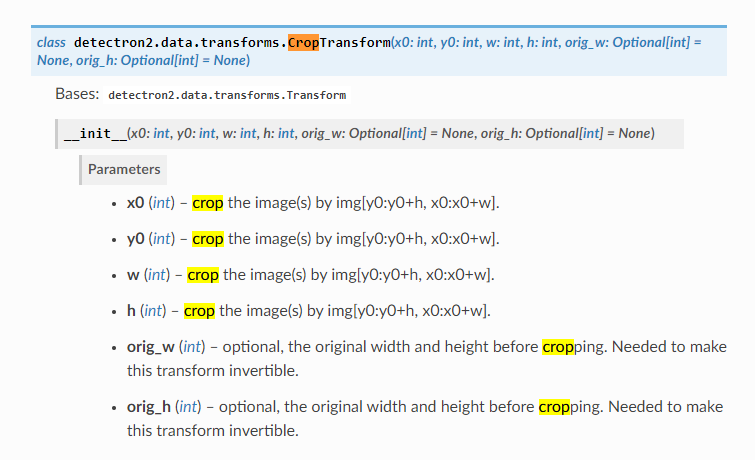

In [ ]:
####### Sauter #######
####### Data augmentation ##############
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
#import detectron2.data.transforms.Augmentation as A
import copy
def custom_mapper(dataset_dict, pad, angle):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    w,h = image.shape[:2]
    transform_list = [
        #T.NoOpTransform(),
        #T.RandomFlip(prob=1, horizontal=True, vertical=False),
        T.RandomRotation(angle=[angle],expand=False,sample_style='choice', center=None),
        T.PadTransform(0,0,pad+1050,pad+1200,0),
        T.CropTransform(pad, pad, w, h, orig_w= w, orig_h=h),
        T.Resize((w,h)),
        #T.RandomLighting(0.5),
        ]
        #T.RandomFlip(prob=0.7, horizontal=False, vertical=True),
       # T.RandomFlip(prob=0.7, horizontal=True, vertical=False),]
   
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict , image

 store augmentation zeyda fel code la remlacer juste par aug_img.to('rgb')

### store augmentaion

In [ ]:
def store_augmentation(outputs,im):
    v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                   scale=1,
                   instance_mode=ColorMode.SEGMENTATION)
    classes = outputs["instances"].gt_classes.to('cpu').tolist()
    boxes = v._convert_boxes(
            outputs["instances"].gt_boxes.to('cpu')).squeeze()  
    label=['cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette']
    data=[]
    if len(classes) != 1:
        for box, clas in zip(boxes, classes):
            class_name = label[clas]
            class_id = clas
            annotations={"bounding_box": [int(box[0]),int(box[1]),int(box[2]),int(box[3])],
                     "category_name": class_name,
                     "category_id":class_id,
                     }
            data.append(annotations)         
    else:
        #label = labels[0]
        clas= classes[0]+1
        class_name = label[clas]
        class_id = clas
        annotations={"bounding_box": [int(boxes[0]),int(boxes[1]),int(boxes[2]),int(boxes[3])],
                     "category_name": class_name,
                     "category_id":class_id,
                     }
        data.append(annotations)
    #img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    aug_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return aug_im, data

### see_me

In [ ]:
def see_me(img):
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

### vizualiz_augmentation(tensor_dict,im)

In [ ]:
def vizualiz_augmentation(outputs,im):
    
    v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                   scale=1,
                   instance_mode=ColorMode.SEGMENTATION)
    
    classes = outputs["instances"].gt_classes.to('cpu').tolist()
    
    boxes = v._convert_boxes(outputs["instances"].gt_boxes.to('cpu')).squeeze()
    scores = classes
    labels = _create_text_labels(classes, scores, ['cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette'])
    if len(labels) != 1:

        for box, label in zip(boxes, labels):
            color = random_color(rgb=True, maximum=1)
            color = v._change_color_brightness(color, 0.5)
            out = v.draw_box(box, edge_color=color)
            
            out = v.draw_text(
                f"{label}", (box[0]+(box[2]-box[0])/2, box[1]), horizontal_alignment="center", font_size=45)
           
    else:
        label = labels[0]
        color = random_color(rgb=True, maximum=1)
        color=v._change_color_brightness(color,0.5)
        out=v.draw_box(boxes,edge_color=color)
        out = v.draw_text(f"{label}", (boxes[0]+(boxes[2]-boxes[0])/2,
                                 boxes[1]), horizontal_alignment="center", font_size=45)
    img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(img)

### blending

In [ ]:
def blending(image, matte, background):

  w, h = image.width, image.height

  rw, rh = 800, int(h * 800 / (3 * w))
  
  background  = background.resize((w,h))

  background = np.asarray(background)
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255   #normalizing 
  #foreground = image * matte + np.full(image.shape, 255) * (1 - matte)

  foreground = image * matte + background * (1 - matte)
  #combined = np.concatenate((img2, foreground), axis=1)
  #combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  blended = Image.fromarray(np.uint8(foreground))
  #combined = Image.fromarray(np.uint8(foreground))
  return blended

In [ ]:
L= os.listdir('/content/drive/MyDrive/pharmacy/data/matte/')
L.pop(1)
print(L)

['0327.png', '0316.png', '0318.png', '0315.png', '0319.png', '0320.png', '0325.png', '0344.png', '0345.png', '0317.png', '0322.png', '0326.png', '0328.png', '0333.png', '0335.png', '0336.png', '0337.png', '0338.png', '0342.png', '0343.png', '0340.png', '0341.png', '0329.png', '0331.png', '0330.png', '0332.png', '0321.png']


In [ ]:
ids=[]
for  a in (L):
    ids.append(int(a[:4]))

In [ ]:
print(len(ids))
#print(ids)

27


In [ ]:
len(glob.glob("data/train/*.jpg"))

30

add tqdm 

In [ ]:
with open("./data/tot_base_train_dict_pascalVoc.json","r") as df:
  data_train = json.load(df)

In [ ]:
outputs, image_rot = custom_mapper(instance_dict,pad,angle)

In [ ]:
!nvidia-smi

Mon Oct 17 06:27:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### single instance augmentation

In [ ]:
dataset_train_dicts = copy.deepcopy(data_train)
#dataset_test_dicts = copy.deepcopy(data_test)
k=7091
background = Image.open("./data/background.jpg")
#for angle , pad in zip(angles,paddings):
for it in range(50):
  for instance_dict in dataset_train_dicts[:30]:
    k+=1
    if int(instance_dict["file_name"].split('/')[-1][:4]) in ids and instance_dict["annotations"][0]["category_id"] in [0,1,2,4,5,6]:
    #if dataset_train_dicts[i]["annotations"][0]["category_id"] in [0,1,2,5]:
      #pad = 0
      pad = random.randrange(200,600)
      #angle = random.randrange(20,180)
      angle = random.randrange(0,260)
      outputs, image_rot = custom_mapper(instance_dict,pad,angle)
      v = Visualizer(image_rot[:, :, ::-1],
                      MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                      scale=1,
                      instance_mode=ColorMode.SEGMENTATION)
        
      bbx = v._convert_boxes(outputs["instances"].gt_boxes.to('cpu')).squeeze().tolist()
      data = copy.deepcopy(instance_dict)

      file_path = data["file_name"]
      matte_name= file_path.split('/')[-1].replace('jpg','png')
      matte_path= "./data/matte/"+matte_name
      matte = Image.open(matte_path)
      matte_rot = matte.rotate(angle=angle,expand=1)
      matte_rot = Image.fromarray(cv2.copyMakeBorder(np.array(matte_rot), pad, 0, pad, 0, cv2.BORDER_CONSTANT, None, value = 0))

      image_org = data["file_name"]
      image_org = Image.open(data["file_name"])

      #file_path = data["file_name"]
      data["image_id"] = k 
      #data["file_name"] = "./data/training/" + str(int(file_path.split('/')[-1][:4])+450).zfill(4)+'.jpg'
      data["file_name"] = "./data/train/" + str(k).zfill(5)+'.jpg'
      data["annotations"][0]["bbox"] = [int(bbx[0]),int(bbx[1]),int(bbx[2]),int(bbx[3])]

      image_rot_pil = Image.fromarray(image_rot)
      wr , hr = image_rot_pil.size
      matte_rot = matte_rot.resize((wr,hr))
      background_rot = background.resize((wr,hr))

      blended_rot = blending(image_rot_pil, matte_rot, background_rot)
      np_blended=np.uint8(blended_rot)

      #vizualiz_augmentation(outputs,np_blended)

      blended_im = cv2.cvtColor(np_blended, cv2.COLOR_BGR2RGB)      
      width, height = (Image.fromarray(blended_im)).size
      data['height'] = height
      data['width'] = width
      plt.imsave(data["file_name"],blended_im)
      data_train.append(data)
      print(k)
      ##dataset_test_dicts.append(data)
      with open("./data/train_long1_1pascalVoc.json",'w') as gp:
        json.dump(data_train,gp)


In [ ]:
with open("./data/train.json",'w') as gp:
        json.dump(data_train,gp)

In [ ]:
len(data_train)

6788

In [ ]:
data_train[-1]

{'file_name': './data/train/03344.jpg',
 'height': 2400,
 'width': 2100,
 'image_id': 3344,
 'annotations': [{'iscrowd': 0,
   'bbox': [875, 804, 1304, 1639],
   'category_id': 4,
   'bbox_mode': 0}]}

In [ ]:
with open("./data/train_long1_pascalVoc.json",'r') as gp:
        json.load(data_train,gp)

In [ ]:
data

In [ ]:
len(dataset_train_dicts)

38

In [ ]:
len(data_train)

38

In [ ]:
len()

In [ ]:
detectron2.data.print_instances_class_histogram(data_train, train_metadata.thing_classes)

[10/17 14:40:57 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cycloff    | 556          |   bibron   | 1383         |  cortéma   | 1108         |
| laroche_posay | 1813         |  soulagel  | 1387         |  sucette   | 560          |
|               |              |            |              |            |              |
|     total     | 6807         |            |              |            |              |


In [ ]:
with open("/content/drive/MyDrive/pharmacy/data/train_long1_pascalVoc.json","r") as df:
  data_train = json.load(df)


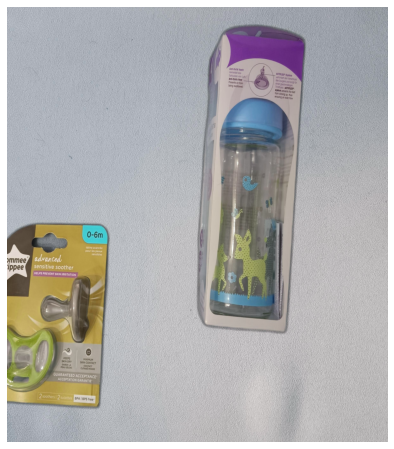

In [ ]:
see_me(image_rot)

In [ ]:
see_me(blended_im)

### augmenting multiclass imgs

In [ ]:
len(synth_dict)

4570

In [ ]:
with open('./data/synthetic_trainset.json','r') as rp:
  synth_dict = json.load(rp)

In [ ]:
#dataset_train_dicts = copy.deepcopy(train_dict)
#dataset_test_dicts = copy.deepcopy(data_test)
k=11039
angle , pad =(0,0)
background = Image.open("./data/background.jpg")
for instance_dict in multiclass_dict[4570:4596]:
  k+=1
  outputs, image_rot =custom_mapper(instance_dict,pad,angle)
  v = Visualizer(image_rot[:, :, ::-1],
                  MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                  scale=1,
                  instance_mode=ColorMode.SEGMENTATION)
  boxes = v._convert_boxes(outputs["instances"].gt_boxes.to('cpu')).squeeze().tolist()
  data = copy.deepcopy(instance_dict)

  file_path = data["file_name"]
  image_org = data["file_name"]
  image_org = Image.open(data["file_name"])

  data["image_id"] = k 
  data["file_name"] = "./data/synthetic_train/" + str(k).zfill(5)+'.jpg'
  if len(data["annotations"])!=1:
    for d , bbx in zip(data["annotations"],boxes):
      d["bbox"] = [int(bbx[0]),int(bbx[1]),int(bbx[2]),int(bbx[3])]
  else:
    data["annotations"][0]["bbox"] = [int(boxes[0]),int(boxes[1]),int(boxes[2]),int(boxes[3])]
 
  vizualiz_augmentation(outputs,image_rot)

  rgb_im = cv2.cvtColor(image_rot, cv2.COLOR_BGR2RGB)      
  width, height = (Image.fromarray(rgb_im)).size
  data['height'] = height
  data['width'] = width
  #plt.imsave(data["file_name"],rgb_im)
  #synth_dict.append(data)
  ##dataset_test_dicts.append(data)
  #with open("./data/train_long1_pascalVoc.json",'w') as gp:
    #json.dump(dataset_train_dicts,gp)
print(k)

In [ ]:
print(k)

11015


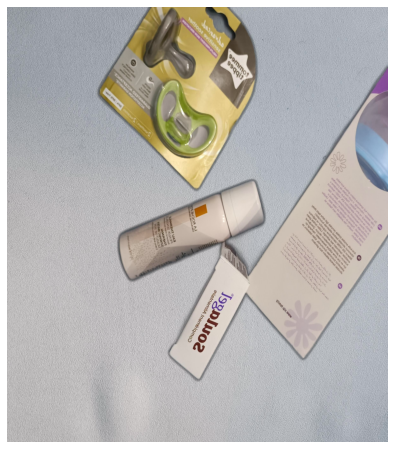

In [ ]:
see_me(image_rot)

 ## **Brouillon**

### another file in th folder

In [ ]:
labeled = pd.read_csv("./data/labels_my-project-name_2022-10-18-01-39-38.csv")

In [ ]:
labeled.head()

label_name  bbox_x  bbox_y  bbox_width  bbox_height image_name  \
0  laroche_posay    1426     556         958          297  01335.jpg   
1        cortema     681     962         870          280  01335.jpg   
2        cycloff    1108    1473         443          627  01335.jpg   
3  laroche_posay     928     728         694          858  01336.jpg   
4        cycloff     886    1456         795          640  01336.jpg   

   image_width  image_height  
0         2400          2100  
1         2400          2100  
2         2400          2100  
3         2400          2100  
4         2400          2100

In [ ]:
labeled.info()

In [ ]:
#labeled["x_max"] = labeled["bbox_x"] + labeled["bbox_width"]
#labeled["y_max"] = labeled["bbox_y"] + labeled["bbox_height"]

In [ ]:
labeled.head(10)

label_name  bbox_x  bbox_y  bbox_width  bbox_height image_name  \
0  laroche_posay    1426     556         958          297  01335.jpg   
1        cortema     681     962         870          280  01335.jpg   
2        cycloff    1108    1473         443          627  01335.jpg   
3  laroche_posay     928     728         694          858  01336.jpg   
4        cycloff     886    1456         795          640  01336.jpg   
5  laroche_posay    1108     682         414          933  01338.jpg   
6       soulagel    1673     473         707          912  01338.jpg   
7        cycloff     895    1623         816          410  01338.jpg   
8  laroche_posay     824     966         962          276  01345.jpg   
9        sucette     815    1259         908          832  01345.jpg   

   image_width  image_height  x_max  y_max  
0         2400          2100   2384    853  
1         2400          2100   1551   1242  
2         2400          2100   1551   2100  
3         2400          2100   1622   1586  
4         2400          2100   1681   2096  
5         2400          2100   1522   1615  
6         2400          2100   2380   1385  
7         2400          2100   1711   2033  
8         2400          2100   1786   1242  
9         2400          2100   1723   2091

In [ ]:
{'file_name': './data/train/0325.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 325,
 'annotations': [{'iscrowd': 0,
   'bbox': [693, 995, 860, 239],
   'category_id': 2,
   'bbox_mode': 0}]}

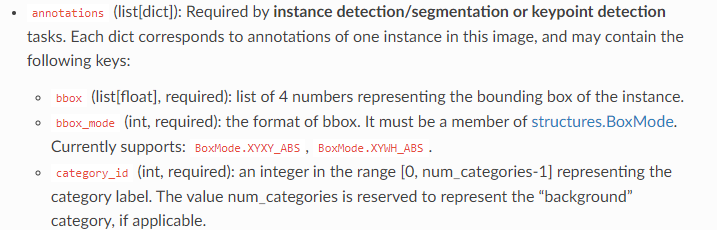

In [ ]:
folder_path = glob.glob('./data/test_synthetic/*.jpg')[0]

In [ ]:
lst = (folder_path.split('/').pop(-1))

In [ ]:
folder_path.replace(folder_path.split('/')[-1],'')

'./data/test_synthetic/'

In [ ]:
folder_path

'./data/test_synthetic/0319.jpg'

In [ ]:
lst.pop(-1)

'0319.jpg'

In [ ]:
lst.join('/')

In [ ]:
clas_lst= ['cycloff', 'bibron', 'cortema', 'laroche_posay', 'soulagel', 'sucette']
img_id = labeled["image_name"][0].split('_')[-1].split('.')[0]
folder_path = glob.glob('./data/test_synthetic/*.jpg')[0]
folder_path = folder_path.replace(folder_path.split('/')[-1],'')
im = Image.open(folder_path + labeled["image_name"][0])
w,h = im.size
a= {'file_name': folder_path + labeled["image_name"][0],
       'height': h,
        'width': w,
        'image_id': int(img_id),
        'annotations': [{'iscrowd': 0,
        'bbox': [int(labeled['bbox_x'][0]),int(labeled['bbox_y'][0]),int(labeled['x_max'][0]),int(labeled['y_max'][0])],
        'category_id': clas_lst.index(labeled["label_name"][0]),
        'bbox_mode': 0}]}

In [ ]:
a

{'file_name': './data/test_synthetic/01335.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 1335,
 'annotations': [{'iscrowd': 0,
   'bbox': [1426, 556, 2384, 853],
   'category_id': 3,
   'bbox_mode': 0}]}

In [ ]:
#/content/drive/MyDrive/pharmacy/data/visual_test_imgs/random_tests/multi_class_input

In [ ]:
labels_dict = []
labels_dict.append(a)
clas_lst= ['cycloff', 'bibron', 'cortema', 'laroche_posay', 'soulagel', 'sucette']
for i in range(1,len(labeled)):
  img_id = labeled["image_name"][i].split('_')[-1].split('.')[0]
  folder_path = glob.glob('./data/test_synthetic/*.jpg')[0]
  folder_path = folder_path.replace(folder_path.split('/')[-1],'')
  im = Image.open( folder_path + labeled["image_name"][0])
  w,h = im.size
  d = {'file_name': folder_path + labeled["image_name"][i],
       'height': h,
        'width': w,
        'image_id': int(img_id),
        'annotations': [{'iscrowd': 0,
        'bbox': [int(labeled['bbox_x'][i]),int(labeled['bbox_y'][i]),int(labeled['x_max'][i]),int(labeled['y_max'][i])],
        'category_id': clas_lst.index(labeled["label_name"][i]),
        'bbox_mode': 1}]}
  if  labeled["image_name"][i] == labeled["image_name"][i-1]:
    labels_dict[len(labels_dict)-1]['annotations'].append(d['annotations'][0])
  else :
    labels_dict.append(d)

In [ ]:
len(labels_dict)

26

In [ ]:
labels_dict[0]

In [ ]:
len(os.listdir('./data/test_synthetic/'))

27

In [ ]:
with open('./data/synthetic_test.json','w') as vp:
  json.dump(labels_dict,vp)

In [ ]:
len(labels_dict)

25

### sanity test

In [ ]:
labels_dict.index(dct)

1

In [ ]:
labels_dict.pop(1)

In [ ]:
dct['file_name']

'./data/test_synthestic/01338.jpg'

In [ ]:
type(im)

NoneType

In [ ]:
/content/drive/MyDrive/pharmacy/data/test_synthetic/01335.jpg

In [ ]:
dct['file_name']

'./data/test_synthestic/01338.jpg'

In [ ]:
im = Image.open('./data/test_synthestic/01338.jpg')
see_me(im)

In [ ]:
labels_dict[1]

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1of130zC4WOxL1MV2r7snVPEROqNr9fgT/pharmacy'

In [ ]:
glob.glob('./data/test_synthetic/*.jpg')

In [ ]:
for dct in labels_dict:
#for file in file_paths:
  im = Image.open(dct['file_name'])
  #im = Image.open(file)
  #see_me(im)
  im= np.uint8(im)
  viz_dict(dct,im)

In [ ]:
labels_dict[6]

In [ ]:
multiclass = labels_dict[6]
for mode in multiclass['annotations']:
  mode['bbox_mode'] = 0

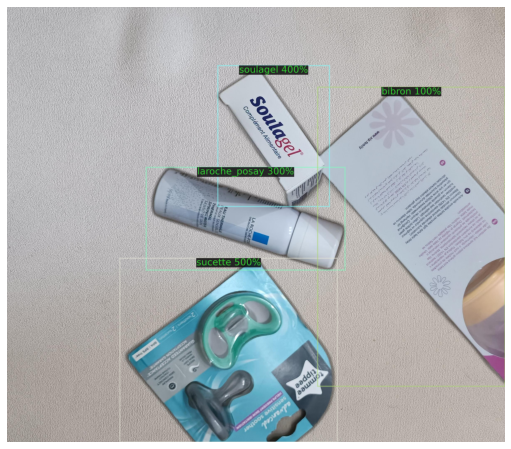

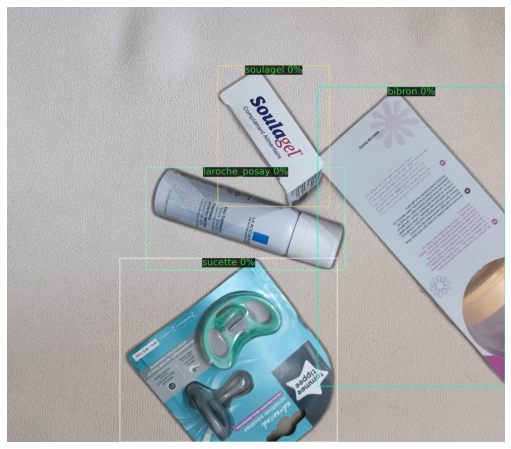

In [ ]:
dct, im = custom_mapper(multiclass,0,0)
vizualiz_augmentation(dct,im)
viz_dict(labels_dict[6],im)

In [ ]:
Affine (translate_px=(100,200), rotate=(0,90), interpolation=1, fit_output=True, keep_ratio=True, always_apply=False, p=1)

In [ ]:
dct['annotations'][1]['bbox']

[124, 1033, 1082, 1495]

In [ ]:
dct['annotations'][i]['bbox'][0]


(911.8699847232265, 182.6549413190485, 2070.1185645307833, 1409.7124674664324)

In [ ]:
dct['annotations'][i]['bbox'][0]

(873.6717403992512, 1507.960404722259, 1530.451156793229, 2542.773302969739)

In [ ]:
dct['annotations'][i]['bbox'][0]

725.6631767379753

In [ ]:
[dct['annotations'][i]['bbox']]

[[725.6631767379753, 363.4127173319664, 2412.911954645403, 2049.0108322556457]]

In [ ]:
dct['annotations'][i]['bbox'][0]

725.6631767379753

In [ ]:
xaug,yaug,w,h = transformed_bboxes[0]

In [ ]:
transform = A.Compose([
    #A.NoOp(),
    A.Affine (translate_px=(0,0), rotate=(0,30), interpolation=1, fit_output=False, keep_ratio=False, always_apply=False, p=1),
    #A.HorizontalFlip(p=1),
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))

In [ ]:
with open('./data/multi_class_dict.json','r') as vp:
  labels_dict = json.load(vp)
  clas_lst= ['cycloff', 'bibron', 'cortema', 'laroche_posay', 'soulagel', 'sucette']
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  for dct in labels_dict:
    im = cv2.imread(dct['file_name'])
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #see_me(im)
    h , w = im.shape[:2]
    #viz_dict(dct,im)
    
    for d in dct['annotations']:
      box = []
      voc_box =d['bbox']
      xmin,ymin,xmax,ymax = voc_box
      coco_box = [xmin,ymin,xmax-xmin,ymax-ymin]
      #box = [d['bbox'][0]/w ,d['bbox'][1]/h,d['bbox'][2]/w,d['bbox'][3]/h]
      box = [coco_box]
      labels = []
      labels.append(clas_lst[d['category_id']])
      transformed = transform(image=im, bboxes=box, class_labels=labels) #class_categories = ['medical']
      transformed_image = transformed['image']
      transformed_bboxes = transformed['bboxes'] #tuple
      xaug,yaug,w,h = transformed_bboxes[0]
      d['bbox'] = [int(xaug),int(yaug),int(xaug+w),int(yaug+h)]
    viz_dict(dct,transformed_image)

In [ ]:
with open('./data/train_base_dict.json','r') as mp:
  base_dict = json.load(mp)

In [ ]:
clas_lst= ['cycloff', 'bibron', 'cortema', 'laroche_posay', 'soulagel', 'sucette']
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for dct in base_dict[:2]:
  im = cv2.imread(dct['file_name'])

  #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  #see_me(im)
  h , w = im.shape[:2]
  #viz_dict(dct,im)
  
  for d in dct['annotations']:
    box = []
    voc_box =d['bbox']
    xmin,ymin,xmax,ymax = voc_box
    coco_box = [xmin,ymin,xmax-xmin,ymax-ymin]
    #box = [d['bbox'][0]/w ,d['bbox'][1]/h,d['bbox'][2]/w,d['bbox'][3]/h]
    box = [coco_box]
    labels = []
    labels.append(clas_lst[d['category_id']])
    transformed = transform(image=im, bboxes=box, class_labels=labels) #class_categories = ['medical']
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes'] #tuple
    xaug,yaug,w,h = transformed_bboxes[0]
    d['bbox'] = [int(xaug),int(yaug),int(xaug+w),int(yaug+h)]
  viz_dict(dct,transformed_image)

In [ ]:
base_dict[5]

{'file_name': './data/train/0320.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 320,
 'annotations': [{'iscrowd': 0,
   'bbox': [696, 1008, 863, 209],
   'category_id': 2,
   'bbox_mode': 1}]}

In [ ]:
base_dict[5]

{'file_name': './data/train/0320.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 320,
 'annotations': [{'iscrowd': 0,
   'bbox': [696, 1008, 1559, 1217],
   'category_id': 2,
   'bbox_mode': 1}]}

In [ ]:
cortema = base_dict[5]
cortema

{'file_name': './data/train/0320.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 320,
 'annotations': [{'iscrowd': 0,
   'bbox': [696, 1008, 863, 209],
   'category_id': 2,
   'bbox_mode': 1}]}

In [ ]:
x,y,w,h= cortema['annotations'][0]['bbox']
cortema['annotations'][0]['bbox'] = [x,y,x+w,y+h]

In [ ]:
cortema

{'file_name': './data/train/0320.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 320,
 'annotations': [{'iscrowd': 0,
   'bbox': [696, 1008, 1559, 1217],
   'category_id': 2,
   'bbox_mode': 1}]}

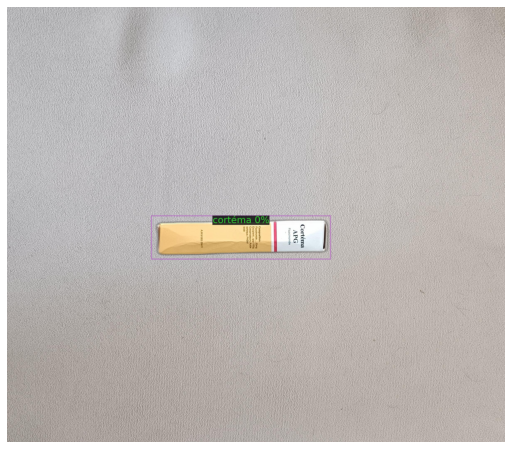

In [ ]:
im = cv2.imread(cortema['file_name'])
viz_dict(cortema,im)

In [ ]:
dct

{'file_name': './data/train/0339.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 339,
 'image': tensor([[[171., 173., 184.,  ..., 148., 139., 137.],
          [167., 170., 181.,  ..., 150., 141., 138.],
          [174., 176., 185.,  ..., 147., 140., 138.],
          ...,
          [163., 158., 152.,  ..., 181., 178., 170.],
          [167., 145., 131.,  ..., 180., 177., 169.],
          [170., 136., 117.,  ..., 181., 176., 168.]],
 
         [[169., 171., 182.,  ..., 157., 148., 146.],
          [165., 168., 179.,  ..., 159., 150., 147.],
          [172., 174., 183.,  ..., 156., 149., 147.],
          ...,
          [168., 163., 157.,  ..., 186., 183., 175.],
          [172., 150., 136.,  ..., 185., 182., 174.],
          [175., 141., 122.,  ..., 186., 181., 173.]],
 
         [[169., 171., 182.,  ..., 166., 157., 155.],
          [165., 168., 179.,  ..., 168., 159., 156.],
          [172., 174., 183.,  ..., 165., 158., 156.],
          ...,
          [177., 172., 166.,  ..., 195.,

In [ ]:
dct, im = custom_mapper(base_dict[5],0,0)
vizualiz_augmentation(dct,im)
viz_dict(cortema,im)

### viz_dict(dict,im)

In [ ]:
def viz_dict(outputs,im):
  v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                   scale=1,
                   instance_mode=ColorMode.SEGMENTATION)
  classes = []
  boxes = []
  scores=[]
  if len(outputs["annotations"]) !=1:
    for d in outputs["annotations"]:
      classes.append(d["category_id"])
      boxes.append(d['bbox'])
      scores.append(0)
  else:
    d = outputs["annotations"][0]
    classes.append(d["category_id"])
    boxes = d['bbox']
    scores.append(0)
  labels = _create_text_labels(classes, scores, ['cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette'])
  
  if len(labels) != 1:
      for box, label in zip(boxes, labels):
          color = random_color(rgb=True, maximum=1)
          color = v._change_color_brightness(color, 0.5)
          out = v.draw_box(box, edge_color=color)
          out = v.draw_text(f"{label}", (box[0]+(box[2]-box[0])/2, box[1]), horizontal_alignment="center", font_size=45)
          
  else:
      label = labels[0]
      color = random_color(rgb=True, maximum=1)
      color=v._change_color_brightness(color,0.5)
      out=v.draw_box(boxes,edge_color=color)
      out = v.draw_text(f"{label}", (boxes[0]+(boxes[2]-boxes[0])/2,
                                boxes[1]), horizontal_alignment="center", font_size=45)
  img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10, 8))
  plt.axis('off')
  plt.imshow(img)

In [ ]:
with open('./data/multi_class_dict.json','w') as vp:
  json.dump(labels_dict,vp)

In [ ]:
with open('./data/multi_class_dict.json','r') as vp:
  labels_dict = json.load(vp)

In [ ]:
'./data/visual_test_imgs/IMG_20220930_185918.jpg'.split('/')

['.', 'data', 'visual_test_imgs', 'IMG_20220930_185918.jpg']

In [ ]:
len(labels_dict)

8

In [ ]:
k=11000
for dct in labels_dict:
  im= Image.open(dct['file_name'])
  dct['file_name'] = './data/train/'+str(k)+'.jpg'
  dct['image_id'] = k
  im.save(dct['file_name'])
  k+=1

In [ ]:
labels_dict[0]

 ### multiclass box mode pascalvoc

In [ ]:
with open('./data/train_base_dict.json','r') as mp:
  base_dict = json.load(mp)
  #clas_lst= ['cycloff', 'bibron', 'cortema', 'laroche_posay', 'soulagel', 'sucette']
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  for dct in base_dict:
    for d in dct['annotations']:
      x,y,w,h= d['bbox']
      d['bbox'] = [x,y,x+w,y+h]
      d['bbox_mode'] = 0

In [ ]:
len(base_dict)

30

In [ ]:
for i in range(len(base_dict)):
  dct, im = custom_mapper(base_dict[i],0,0)
  vizualiz_augmentation(dct,im)

In [ ]:
base_dict[:2]

[{'file_name': './data/train/0315.jpg',
  'height': 2100,
  'width': 2400,
  'image_id': 315,
  'annotations': [{'iscrowd': 0,
    'bbox': [518, 738, 2015, 1359],
    'category_id': 1,
    'bbox_mode': 0}]},
 {'file_name': './data/train/0316.jpg',
  'height': 2100,
  'width': 2400,
  'image_id': 316,
  'annotations': [{'iscrowd': 0,
    'bbox': [561, 731, 2025, 1306],
    'category_id': 1,
    'bbox_mode': 0}]}]

In [ ]:
len(labels_dict)

8

In [ ]:
len(base_dict)

30

In [ ]:
total_dict = base_dict + labels_dict

In [ ]:
len(total_dict)

38

In [ ]:
len(total_dict[])

36

In [ ]:
with open('./data/tot_base_train_dict_pascalVoc.json','w') as kp:
  json.dump(total_dict,kp)

### background_removal

In [ ]:
mask = Image.open('/content/drive/MyDrive/pharmacy/data/matte/0321.png')
background = Image.open("./data/background.jpg")
soulagel_2= Image.open("./cortema.jpg")
soulagel_bld = blending(soulagel_2, mask, background)

In [ ]:
see_me(soulagel_bld)

In [ ]:
'./data/matte/0341.png'.replace('matte','train').replace('png','jpg')

'./data/train/0341.jpg'

In [ ]:
soulagel_bld.save('./data/train/0340.jpg')

In [ ]:
soulagel_1 = Image.fromarray(cv2.copyMakeBorder(np.array(soulagel), 45,0 , 0, 0, cv2.BORDER_CONSTANT, None, value = 0)[:2100,:,:])

In [ ]:
see_me(cv2.copyMakeBorder(np.array(soulagel), 10, 0, 0, 0, cv2.BORDER_CONSTANT, None, value = 0)[:2100,:,:])

In [ ]:
cv2.copyMakeBorder(np.array(soulagel), 10, 0, 0, 0, cv2.BORDER_CONSTANT, None, value = 0).shape[:2]

(2110, 2400)

#### rmvbg

In [ ]:
from rembg import remove

In [ ]:
from rembg import remove
input_path = "./cortema.jpg"
output_path = "./data/output_rembg.png"
input = Image.open(input_path)
output = remove(input)
see_me(output)

In [ ]:
bg_img = Image.open("./data/background.png")

In [ ]:
print(bg_img.size)
print(output.size)

(2400, 2100)
(2400, 2100)


Downloading...
From: https://drive.google.com/uc?id=1tCU5MM1LhRgGou5OpmpjBQbSrYIUoYab
To: /root/.u2net/u2net.onnx
100%|██████████| 176M/176M [00:01<00:00, 114MB/s] 


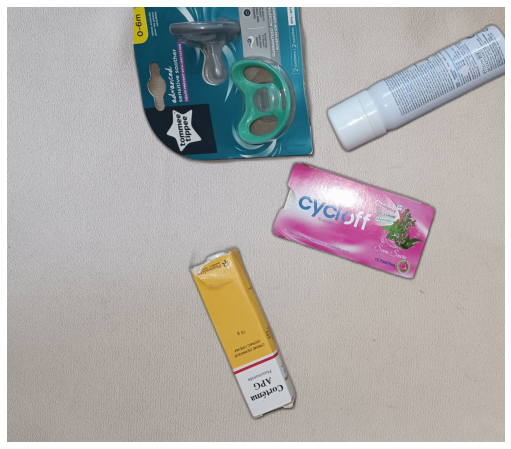

In [ ]:
bg_img = Image.open("./data/background.png")
multi_class = Image.open("./data/IMG_20220930_194547.jpg")
output = remove(multi_class).convert('RGBA')
output = output.rotate(angle=90)
bg_img.paste(output,box=(300,0), mask = output)
see_me(bg_img)

In [ ]:
print(input.size)
input = input.resize((2400,2100))
print(input.size)

(2850, 2230)
(2400, 2100)


In [ ]:
for input_path in glob.glob('./data/visual_test_imgs/random_tests/multi_class_input/*.jpg'):
  output_path = input_path.replace('input','output').replace('jpg','png')
  input = Image.open(input_path)
  input = input.resize((2400,2100))
  output = remove(input)
  see_me(output)
  output.save(output_path)
  bg_img = Image.open("./data/background.png")
  output.convert('RGBA')
  bg_img.paste(output,box=(0,0), mask = output)
  see_me(bg_img)
  bg_img.save(input_path)

#### syntetic data for test multiclass imgs

In [ ]:
os.listdir('./data/foreground/')

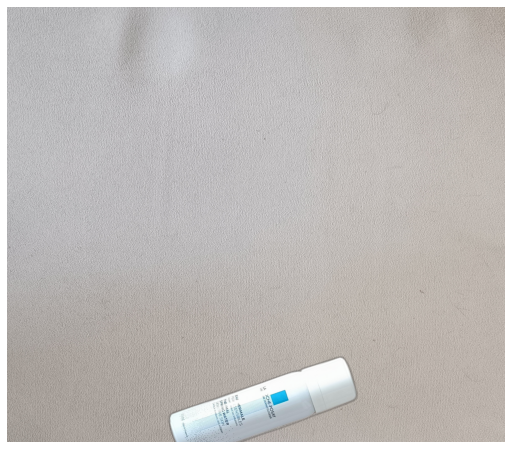

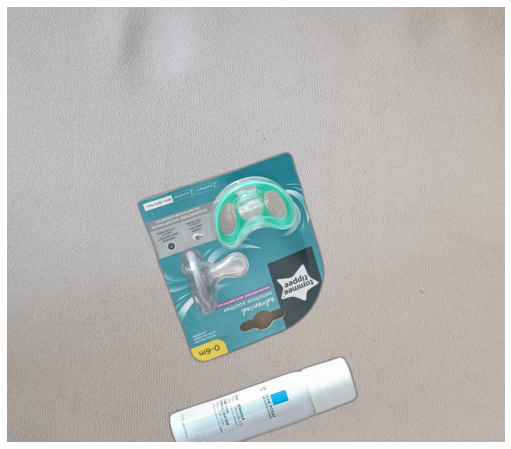

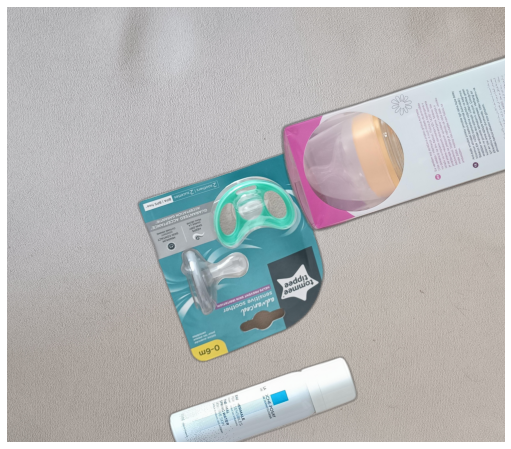

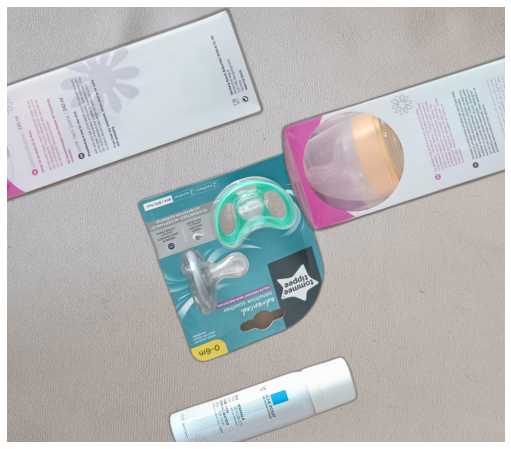

In [ ]:
bg_img = Image.open("./data/background.png")
i =0 
k=416
for filename, (pos1,pos2)  in zip(os.listdir('./data/foreground/')[:4], [(100,800),(0,0),(800,-400),(-800,-500)]):
  input_path =  './data/foreground/' + filename 
  
  output = Image.open(input_path)
  #angle = random.randrange(15,90)
  angle = 20
  output = output.convert('RGBA').rotate(angle)
  
  bg_img.paste(output,box=(pos1,pos2), mask = output)
  i+=1
  if i ==5:
    break
  see_me(bg_img)
  k+=1
  bg_img.save(input_path.replace('foreground','synthetic').replace(filename,str(k)+'.jpg'))

### Data augmentation with synthetic data


In [ ]:
train_dict[10]

{'file_name': './data/train/0326.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 326,
 'annotations': [{'iscrowd': 0,
   'bbox': [1017, 659, 1445, 1440],
   'category_id': 0,
   'bbox_mode': 0}]}

In [ ]:
dict_tr , im_tr = custom_mapper(train_dict[10],500,0)

In [ ]:
x1,y1,x2,y2 = train_dict[7]['annotations'][0]['bbox']

In [ ]:
w,h = x2-x1 , y2-y1

In [ ]:
print('x1', x1, 'y1',y1,'w',w,'h',h)

x1 900 y1 962 w 387 h 267


In [ ]:
dict_tr

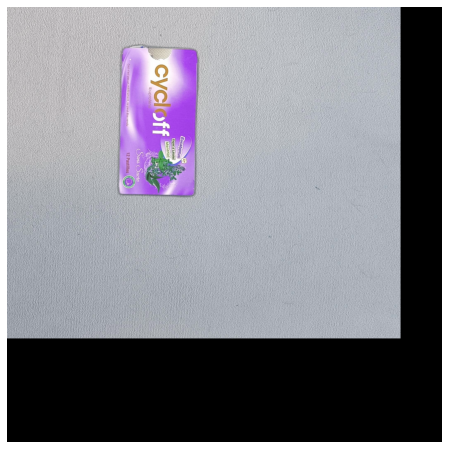

In [ ]:
see_me(im_tr)

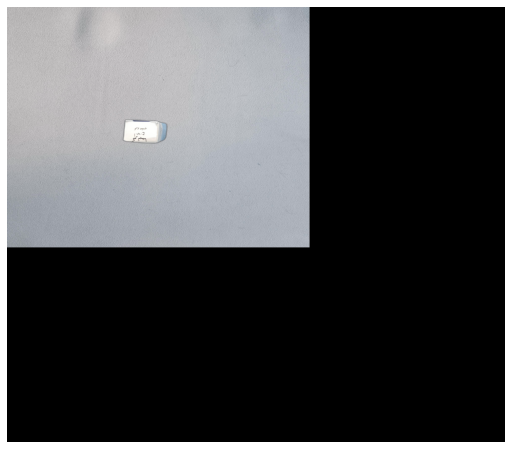

In [ ]:
see_me(im_tr)

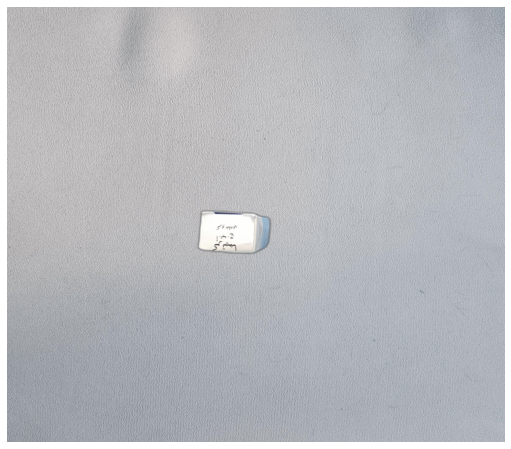

In [ ]:
im = cv2.imread(dict_tr['file_name'])
see_me(im)

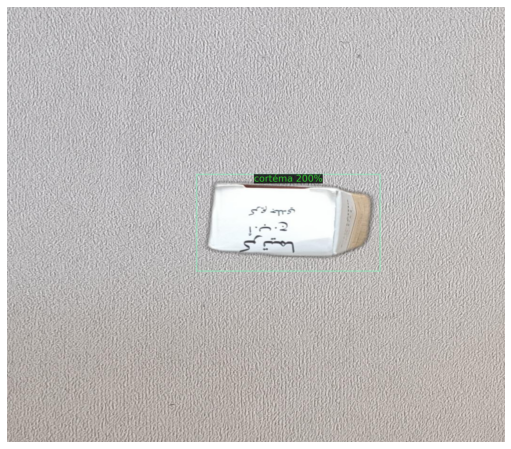

In [ ]:
vizualiz_augmentation(dict_tr,im_tr)

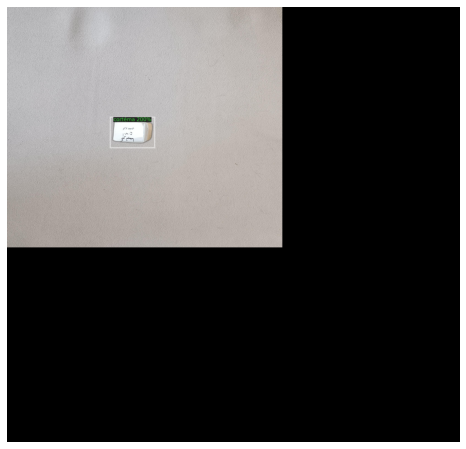

In [ ]:
vizualiz_augmentation(dict_tr,im_tr)

In [ ]:
len(os.listdir('./data/foreground/'))

30

In [ ]:
train_dict[:30]

In [ ]:
len(train_dict[:30])

30

In [ ]:
train_dict[29]

{'file_name': './data/train/0339.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 339,
 'annotations': [{'iscrowd': 0,
   'bbox': [915, 654, 1483, 1507],
   'category_id': 4,
   'bbox_mode': 0}]}

In [ ]:
train_dict[29]['file_name'].split('/')[-1].replace('jpg','png')

'0339.png'

In [ ]:
synth_dict = []

In [ ]:
len(train_dict)

6788

In [ ]:
train_dict[0]

{'file_name': './data/train/0315.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 315,
 'annotations': [{'iscrowd': 0,
   'bbox': [518, 738, 2015, 1359],
   'category_id': 1,
   'bbox_mode': 0}]}

#### synth dict

In [ ]:
#i =10 
k=1000
angle = random.randrange(15,90)
pad = -random.randrange(300,700) #top left  and positive means right
#angle = 0 
#pad = 0
#angle = random.randrange(15,180)
for it in range(2):
  pad = -random.randrange(200,500)
  #angle = random.randrange(0,20)
  for i  in  range(len(train_dict[:1])):
    filename = train_dict[i]['file_name'].split('/')[-1].replace('jpg','png')
    input_path =  './data/foreground/' + filename 
    output = Image.open(input_path)
    #angle = random.randrange(15,90)
    output = output.convert('RGBA').rotate(angle)
    dict_tr , im_tr = custom_mapper(train_dict[i],abs(pad),angle) #angle et valeur du padding
    v = Visualizer(im_tr[:, :, ::-1],
                        MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                        scale=1,
                        instance_mode=ColorMode.SEGMENTATION)
          
    bbx = v._convert_boxes(dict_tr["instances"].gt_boxes.to('cpu')).squeeze().tolist()
    bg_img = Image.open("./data/background.png")

    bg_img.paste(output,box=(pad,pad), mask = output) #position of foreground
    bg_img = np.uint8(bg_img)
    vizualiz_augmentation(dict_tr,bg_img)
    #store annotations
    data = copy.deepcopy(train_dict[i])
    data["image_id"] = k 
    data["file_name"] = "./data/test_synthetic/" + str(k).zfill(4)+'.jpg'
    data["annotations"][0]["bbox"] = [int(bbx[0]),int(bbx[1]),int(bbx[2]),int(bbx[3])]
    width, height = (Image.fromarray(bg_img)).size
    data['height'] = height
    data['width'] = width
    #synth_dict.append(data)
    #see_me(bg_img)
    #Image.fromarray(bg_img).save(data["file_name"])
    k+=1
    print(k)

In [ ]:
len(synth_dict)

4530

In [ ]:
detectron2.data.print_instances_class_histogram(synth_dict, train_metadata.thing_classes)

[10/19 14:23:43 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cycloff    | 2            |   bibron   | 5            |  cortéma   | 5            |
| laroche_posay | 9            |  soulagel  | 7            |  sucette   | 2            |
|               |              |            |              |            |              |
|     total     | 30           |            |              |            |              |


In [ ]:
detectron2.data.print_instances_class_histogram(synth_dict, train_metadata.thing_classes)

[10/19 16:39:21 d2.data.build]: Distribution of instances among all 6 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    cycloff    | 333          |   bibron   | 776          |  cortéma   | 785          |
| laroche_posay | 1394         |  soulagel  | 1096         |  sucette   | 348          |
|               |              |            |              |            |              |
|     total     | 4732         |            |              |            |              |


In [ ]:
with open('./data/synthetic_trainset.json','w') as xp:
  json.dump(synth_dict,xp)

In [ ]:
with open('./data/synthetic_trainset.json','r') as rp:
  synth_dict = json.load(rp)


In [ ]:
len(multiclass_dict)-26

4570

In [ ]:
multiclass_dict[4570:4596]

[{'file_name': './data/synthetic_train/01335.jpg',
  'height': 2100,
  'width': 2400,
  'image_id': 1335,
  'annotations': [{'iscrowd': 0,
    'bbox': [1426, 556, 2384, 853],
    'category_id': 3,
    'bbox_mode': 0},
   {'iscrowd': 0,
    'bbox': [681, 962, 1551, 1242],
    'category_id': 2,
    'bbox_mode': 1},
   {'iscrowd': 0,
    'bbox': [1108, 1473, 1551, 2100],
    'category_id': 0,
    'bbox_mode': 1}]},
 {'file_name': './data/synthetic_train/01336.jpg',
  'height': 2100,
  'width': 2400,
  'image_id': 1336,
  'annotations': [{'iscrowd': 0,
    'bbox': [928, 728, 1622, 1586],
    'category_id': 3,
    'bbox_mode': 1},
   {'iscrowd': 0,
    'bbox': [886, 1456, 1681, 2096],
    'category_id': 0,
    'bbox_mode': 1}]},
 {'file_name': './data/synthetic_train/01338.jpg',
  'height': 2100,
  'width': 2400,
  'image_id': 1338,
  'annotations': [{'iscrowd': 0,
    'bbox': [1108, 682, 1522, 1615],
    'category_id': 3,
    'bbox_mode': 1},
   {'iscrowd': 0,
    'bbox': [1673, 473, 2380,

In [ ]:
len(multiclass_dict)

26

In [ ]:
for d in multiclass_dict:
  file_path1 = d['file_name']
  d['file_name'] = d['file_name'].replace('test_synthetic','synthetic_train')
  shutil.copy(file_path1,d['file_name'])

In [ ]:
for d in multiclass_dict:
  synth_dict.append(d)

In [ ]:
len(synth_dict)

4596

In [ ]:
synth_dict

In [ ]:
multiclass_dict[]

In [ ]:
multiclass_dict.index(taswira)

4588

In [ ]:
taswira['bbox_mode'] = 0

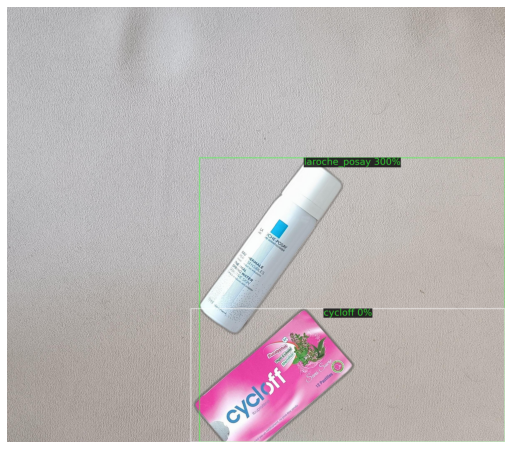

In [ ]:
j=4595
for taswira in random.sample(multiclass_dict[4570:4596], 1):
  taswira['bbox_mode'] = 0
  im=cv2.imread(taswira['file_name'])
  dct, imtr = custom_mapper(taswira,0,0)
  vizualiz_augmentation(dct,imtr)
  viz_dict(taswira,im)

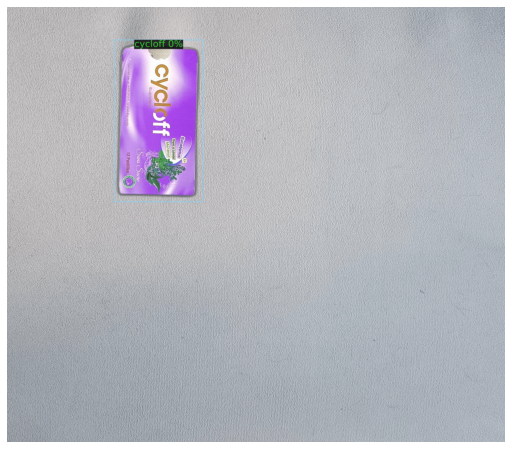

In [ ]:
bg_img = np.uint8(bg_img)
#dict_tr
vizualiz_augmentation(dict_tr,bg_img)

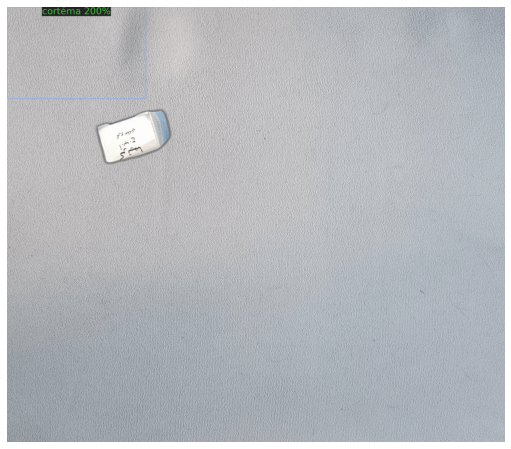

In [ ]:
vizualiz_augmentation(dict_tr,bg_img)

 #### Load basic annoatation dict 

In [ ]:
with open('/content/drive/MyDrive/pharmacy/data/train_base_dict.json','r') as mp:
  dicte = json.load(mp)

In [ ]:
print(dicte.index(d))
d

9


{'file_name': './data/train/0325.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 325,
 'annotations': [{'iscrowd': 0,
   'bbox': [693, 995, 860, 239],
   'category_id': 2,
   'bbox_mode': 1}]}

In [ ]:
s_339 = dicte[-7]

In [ ]:
s_339['file_name']= s_339['file_name'].replace('0338','0339')
s_339['image_id']=339
s_339

{'file_name': './data/train/0339.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 339,
 'annotations': [{'iscrowd': 0,
   'bbox': [915, 654, 568, 853],
   'category_id': 4,
   'bbox_mode': 1}]}

In [ ]:
#dicte.append(s_339)

In [ ]:
#with open('/content/drive/MyDrive/pharmacy/data/train_base_dict.json','w') as mp:
#  json.dump(dicte,mp)

In [ ]:
'''
img = cv2.imread(d['file_name'])
#mask= np.zeros_like(img)
mask = np.zeros((2400,2100),dtype=np.int8)
see_me(mask)
box =d['annotations'][0]['bbox']
mask[box[0]:box[2],box[1]:box[3]] = 1
see_me(mask)

array([], shape=(246, 0), dtype=int8)

In [ ]:
see_me(mask[box[0]:box[2],box[1]:box[3]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  after removing the cwd from sys.path.


In [ ]:
see_me(mask)

In [ ]:
for d in dicte[:]:
  tenseor_dict , im_tr = custom_mapper(d,0,0)
  vizualiz_augmentation(tenseor_dict,im_tr)

In [ ]:
glob.glob("./data/visual_test_imgs/random_tests/cropped/*.jpg")[:5]

['./data/visual_test_imgs/random_tests/cropped/biberon (1).jpg',
 './data/visual_test_imgs/random_tests/cropped/biberon (2).jpg',
 './data/visual_test_imgs/random_tests/cropped/biberon (3).jpg',
 './data/visual_test_imgs/random_tests/cropped/biberon (4).jpg',
 './data/visual_test_imgs/random_tests/cropped/biberon (5).jpg']

In [ ]:
sorted(glob.glob("./data/visual_test_imgs/random_tests/cropped/*.jpg"))[29:]

['./data/visual_test_imgs/random_tests/cropped/sucette (1).jpg',
 './data/visual_test_imgs/random_tests/cropped/sucette (2).jpg']

In [ ]:
#k=343
file_path="./data/visual_test_imgs/random_tests/cropped/soulagel (7).jpg"
#for file_path in sorted(glob.glob("./data/visual_test_imgs/random_tests/cropped/*.jpg")):
bg_img = Image.open("./data/background.png")
multi_class = Image.open(file_path)
output = remove(multi_class).convert('RGBA')
#output = output.rotate(angle=30)
bg_img.paste(output,box=(0,0), mask = output)
see_me(bg_img)
  #bg_img.save('./data/train/'+str(k).zfill(4)+'.jpg')
  #k+=1

(2850, 2230)
(2400, 2100)


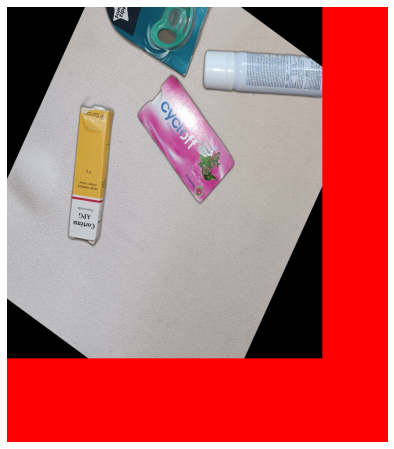

(2100, 2400)


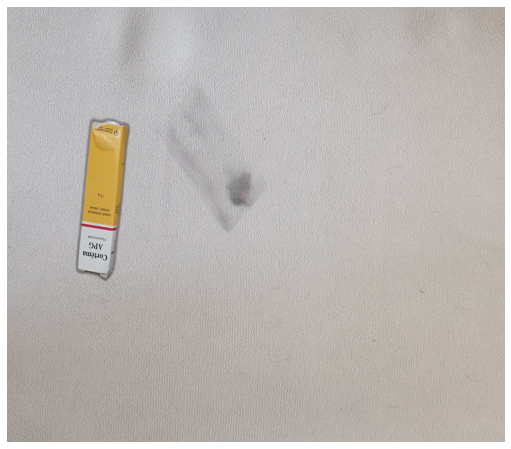

In [ ]:
angle = 60
pad = 500
print(multi_class.size)
rot = bg_img.rotate(angle=angle,expand=0).resize((2400,2100))
print(rot.size)
rot = Image.fromarray(cv2.copyMakeBorder(np.array(rot), 0, pad, 0, pad, cv2.BORDER_CONSTANT, None, value = 255)[:,:]).resize((2100,2400))
see_me(rot)
print(rot.size)
bg_img1 = Image.open("./data/background.png")

output = remove(rot).convert('RGBA')
bg_img1.paste(output,box=(0,0), mask = output)
see_me(bg_img1)

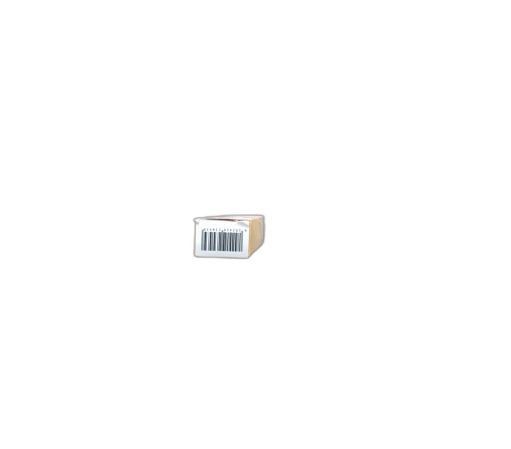

In [ ]:
see_me(output)

In [ ]:
output = output.convert('RGBA')
bg_img.paste(output,box=(0,0), mask = output)
display(bg_img)

In [ ]:
output = output.convert('RGBA')
bg_img.paste(output,box=(0,0), mask = output)

In [ ]:
output.save('output.png')

In [ ]:
output.size

(2400, 2100)

In [ ]:
background.size

(2400, 2100)

In [ ]:
src1 = cv2.imread('background.jpg',cv2.IMREAD_COLOR)
src2 = cv2.imread('output.png',cv2.IMREAD_COLOR)

# add or blend the images
dst = cv2.addWeighted(src1, 0.5, src2, 0.5, 0.0)
see_me(dst)
# save the output image
#cv2.imwrite('image.png', dst)

In [ ]:
print(type(output))
print("size:",output.size)

<class 'PIL.Image.Image'>
size: (2400, 2100)


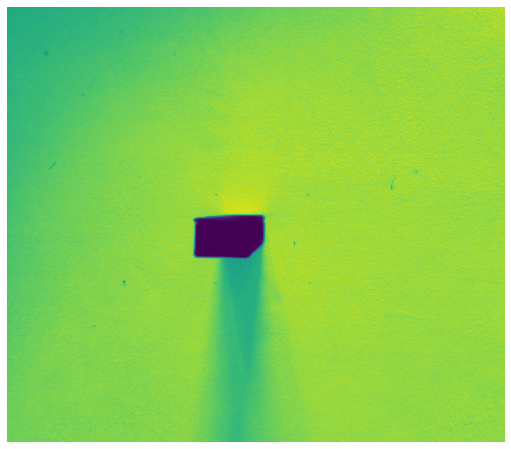

In [ ]:
see_me(np.array(input.convert('L'))-np.array(gray))
mask3 = np.array(input.convert('L'))-np.array(gray)

In [ ]:
bin3 = Image.fromarray(mask3).point(lambda x: 0 if x < 128 else 255, '1')

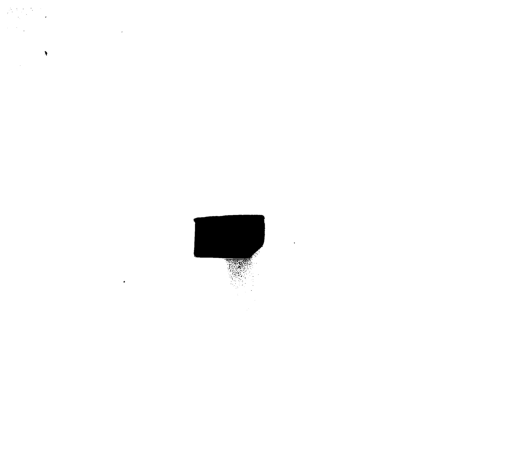

In [ ]:
see_me(bin3)

In [ ]:
cortema_bld = blending(cortema_2, bin3, background)

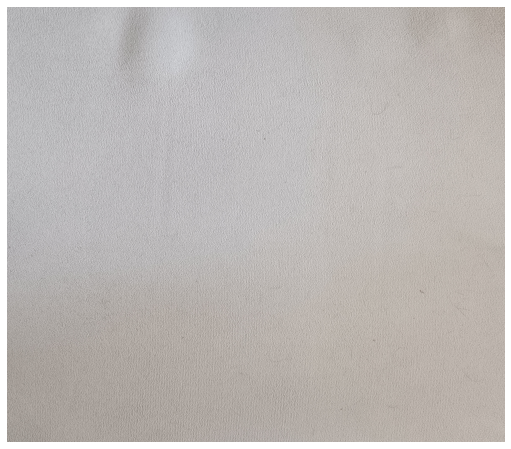

In [ ]:
see_me(cortema_bld)

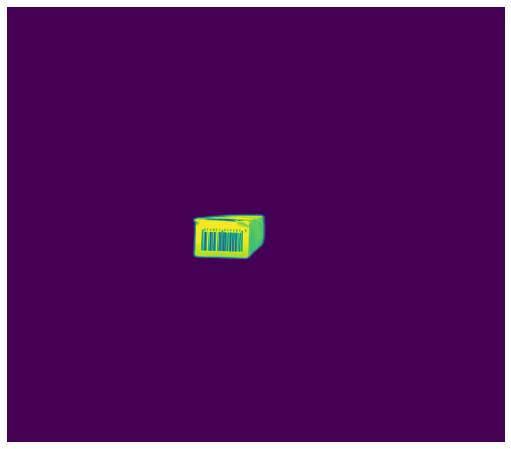

In [ ]:
#see_me(output.convert('L'))
gray = np.array(output.convert('L'))
see_me(gray)

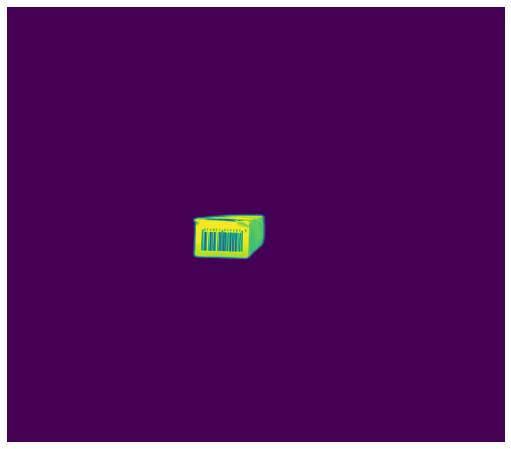

In [ ]:
see_me(gray)

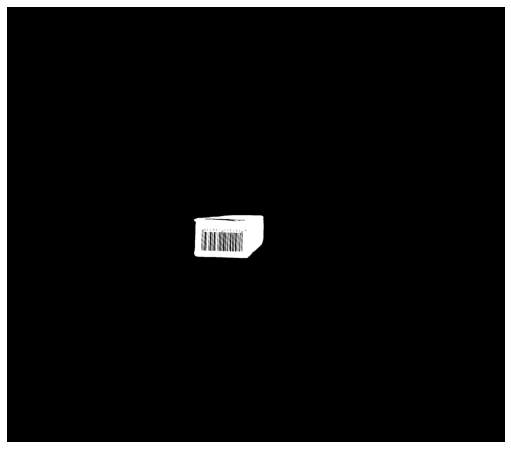

In [ ]:
Gray_scale = output.convert('L')
binary = Gray_scale.point(lambda x: 0 if x<128 else 255, '1')
see_me(binary)

In [ ]:
type(binary)

PIL.Image.Image

In [ ]:
type(gray)

numpy.ndarray

In [ ]:
gray.shape

(2100, 2400)

In [ ]:
gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
type(np.array(mask))

numpy.ndarray

In [ ]:
mask = np.array(mask)
type(mask)

numpy.ndarray

In [ ]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
mask2 = Image.fromarray(gray)
background = Image.open("./data/background.jpg")
cortema_2= Image.open("./cortema.jpg")
cortema_bld = blending(cortema_2, mask2, background)

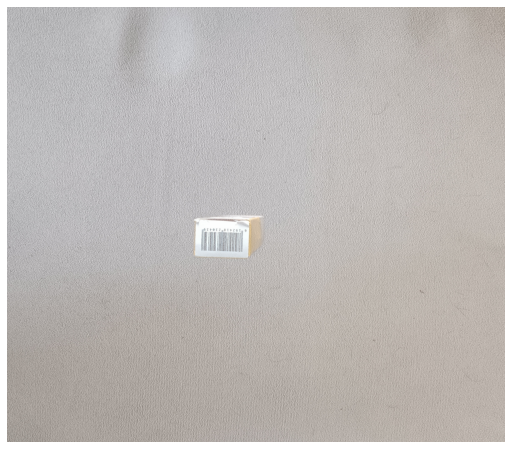

In [ ]:
see_me(cortema_bld)

In [ ]:
cortema_bin = blending(cortema_2, binary, background)

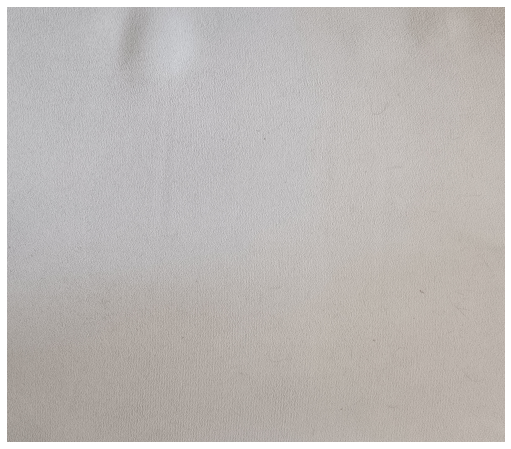

In [ ]:
see_me(cortema_bin)

In [ ]:
cortema_bld.save('./data/train/0321.jpg')

### **New base dict**

In [ ]:
with open("./data/train1.json",'r') as gd:
  data_train = json.load(gd)

In [ ]:
len(data_train)

429

In [ ]:
#data_train = data_train[:28]

In [ ]:
data_train[:5]

In [ ]:
#soulagel_341 = data_train[23]

In [ ]:
#soulagel_341['file_name'] = './data/training/0341.jpg'

In [ ]:
soulagel_341

{'file_name': './data/training/0341.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 340,
 'annotations': [{'iscrowd': 0,
   'bbox': [693, 934, 939, 316],
   'category_id': 4,
   'bbox_mode': 1}]}

In [ ]:
#data_train.append(soulagel_341)

In [ ]:
data_train[-1]

{'file_name': './data/training/0341.jpg',
 'height': 2100,
 'width': 2400,
 'image_id': 340,
 'annotations': [{'iscrowd': 0,
   'bbox': [693, 934, 939, 316],
   'category_id': 4,
   'bbox_mode': 1}]}

In [ ]:
for dt in data_train:
  old_path =dt['file_name']
  new_path = old_path.replace('training','train')
  dt['file_name'] = new_path
  shutil.move(old_path,new_path)

In [ ]:
for dt in data_train:
  print(dt['file_name'])

In [ ]:
with open("./data/train_base_dict.json","w") as df:
  json.dump(data_train,df)

In [ ]:
detectron2.data.print_instances_class_histogram(dataset_test_dicts, test_metadata.thing_classes)

In [ ]:
for i in range(len(dataset_train_dicts[:12])):
    #if dataset_train_dicts[i]["annotations"][0]["category_id"] in [1,2,5]:
    print(dataset_train_dicts[i])

In [ ]:
dataset_train_dicts[26]

In [ ]:
data

In [ ]:
see_me(image_rot)

In [ ]:
see_me(cv2.copyMakeBorder(np.array(matte), 500, 0, 500, 0, cv2.BORDER_CONSTANT, None, value = 0))

In [ ]:
see_me(matte_rot)

In [ ]:
data = copy.deepcopy(dataset_train_dicts[11])

In [ ]:
data

In [ ]:
img = Image.open(data['file_name'])

In [ ]:
img =img.rotate(angle=0,expand=1,center=None,translate=(100,100))

In [ ]:
img.size

In [ ]:
see_me(img)

In [ ]:
matte = Image.open(data['file_name'].replace('training','matte').replace('jpg','png'))

In [ ]:
matte_img = matte.rotate(angle=0,expand=1,center=None,translate=(100,100))

In [ ]:
matte_img.size

In [ ]:
see_me(matte_img)

In [ ]:
background = Image.open("./data/background.jpg")

In [ ]:
pil_bld = blending(img, matte_img, background)

In [ ]:
see_me(blending(img, matte_img, background))

In [ ]:
data 

In [ ]:
data["annotations"][0]

In [ ]:
if True :
  pil_bld = np.uint8(pil_bld) 
  v = Visualizer(pil_bld[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                   scale=1,
                   instance_mode=ColorMode.SEGMENTATION)
  classes = [data["annotations"][0]["category_id"]]
  bbx = data["annotations"][0]["bbox"]
  #boxes = [bbx[0]+300,bbx[1]-120,bbx[2]+250,bbx[3]-50]
  boxes = [bbx[0]+100,bbx[1]+100,bbx[2]+200,bbx[3]+200]
  #boxes = list((boxes+2).astype(np.int32))
  #boxes = int(list(boxes))
  scores = classes
  labels = _create_text_labels(
          classes, scores, ['cycloff', 'bibron', 'cortéma', 'laroche_posay','soulagel', 'sucette'])
    #label={"cycloff":1,"bibron":2,"cortéma":3,"laroche_posay":4,"soulagel":5,"sucette":6}
          
  if len(labels) == 1:
    label = labels[0]
    #clas= classes[0]
    color = random_color(rgb=True, maximum=1)
    color=v._change_color_brightness(color,0.5)
    out=v.draw_box((boxes[0]+100,boxes[1]+100,boxes[2]+100,boxes[3]+100),alpha=0.8,edge_color=color)
    #out = v.draw_text(f"{label}", (boxes[0]+(boxes[2]-boxes[0])/2,
                             # boxes[1]), horizontal_alignment="center", font_size=45)
    #img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    img = out.get_image()[:, :, ::-1]
    plt.figure(figsize=(10, 8))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
vizualiz_augmentation(outputs,image_rot)

In [ ]:
see_me(matte_rot)

In [ ]:
matte_rot.size

In [ ]:
 image_rot_pil.size

In [ ]:
img_org = Image.open('./data/training/0513.jpg').rotate(180, expand=1, center=(635,1451), translate=(10,10), fillcolor=None)

In [ ]:
Image.open('./data/training/0513.jpg').size

In [ ]:
im = Image.open('/content/drive/MyDrive/pharmacy/data/matte/0326.png').resize((2100,2400))

In [ ]:
im= im.rotate(180, expand=1, center=(635,1451), translate=(10,10), fillcolor=None)

In [ ]:
see_me(blending(img_org, im, background))

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "logs/model_0012459.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator(data_test_name,tasks=("bbox",),output_dir="./data/dict_result")

val_loader = build_detection_test_loader(cfg, "data_test")

data = inference_on_dataset(predictor.model, val_loader, evaluator)

print(data)
with open('./data/dict_result/model_0012459_.json', 'w') as fp:
        json.dump(data, fp)